In [11]:
!pip install rich-msa
!pip install xmltramp2

# some extra packages that I needed to install

In [27]:
import os.path
from pathlib import Path
import numpy as np
import pandas as pd
import re
import json

from papyrus_scripts.download import download_papyrus
from papyrus_scripts.reader import read_papyrus, read_protein_set
from papyrus_scripts.preprocess import *
from papyrus_scripts.utils.IO import get_num_rows_in_file

from Bio.Seq import Seq
from Bio.SeqIO import SeqRecord, write as SeqIO_write, parse as SeqIO_parse
from Bio.Align.Applications import ClustalOmegaCommandline
import Bio.AlignIO
import rich
from rich_msa import RichAlignment

from prodec import ProteinDescriptors
from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [29]:
PAPYRUS_VERSION = '05.6' # the version of papyrus we used

In [30]:
download_papyrus(outdir=DATA, version=PAPYRUS_VERSION, nostereo=True, stereo=False, descriptors=None) # downloads papyrus

########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 3
Total size: 33.0MB


In [31]:
def filter_explore_activity_data(papyrus_version, targets): # this function will be used to fetch data from papyrus

    # Read downloaded Papyrus dataset in chunks, as it does not fit in memory
    CHUNKSIZE = 100000
    data = read_papyrus(version=papyrus_version, chunksize=CHUNKSIZE, source_path=DATA)

    # Create filter for targets of interest
    target_accession_list = targets.values()
    filter = keep_accession(data, target_accession_list)

    # Iterate through chunks and apply the filter defined
    filtered_data = consume_chunks(filter, total=-(-get_num_rows_in_file('bioactivities', False) // CHUNKSIZE))
    # Add column named 'Target' for easier data visualization
    filtered_data['Target'] = filtered_data['accession'].apply(lambda x: [i for i in targets.keys() if targets[i]==x][0])

    # Print number of bioactivity datapoints per target
    for target,accession in zip(targets.keys(), targets.values()):
        print('Number of bioactivity datapoints')
        print(f'{target} ({accession}) : {filtered_data[filtered_data["accession"]==accession].shape[0]}')

    # Plot distribution of activity values (pchembl_value_Mean) per target
    g = sns.displot(filtered_data, x='pchembl_value_Mean', hue='Target', element='step', hue_order=targets.keys())

    return filtered_data

  0%|          | 0/13 [00:00<?, ?it/s]

Number of bioactivity datapoints
A3 (P0DMS8) : 3244


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


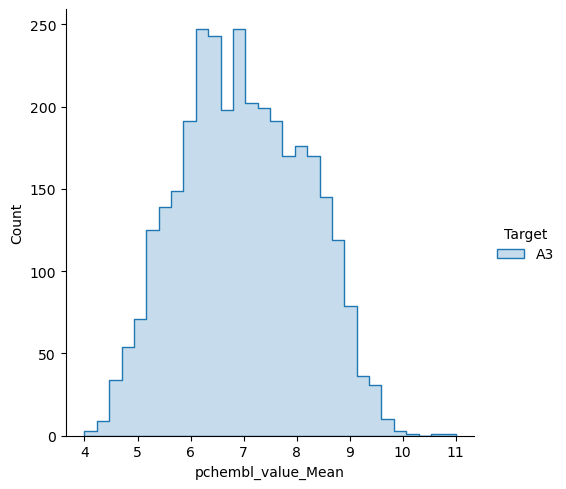

In [32]:
adenosine_receptors = {'A3': 'P0DMS8'} # for our project we just want the list of ligands of A3


#adenosine_receptors = {'A1': 'P30542',
#                      'A2A': 'P29274',
#                      'A2B': 'P29275',
#                      'A3': 'P0DMS8'} # these were the receptors with selected as standards for this tutorial, we only need A3

# this filters the bioactivity dataset and plots the pChEMBL values for selected targets (A3)
ar_data = filter_explore_activity_data(PAPYRUS_VERSION, adenosine_receptors) # it kept getting stuck on 5/13, so that is what we decided to use

In [33]:
ar_dataset = ar_data[['SMILES', 'pchembl_value_Mean']] # selected columns from the fetched data
ar_dataset # this is the dataset with the ligands but the index is all screwed up
ar_dataset.reset_index(drop=False, inplace=True)
ar_dataset.drop(columns=['index'],inplace=True) #now the index is right
ar_dataset = ar_dataset.rename(columns={'SMILES':'smiles','pchembl_value_Mean':'pchembl'}) #renames column
display(ar_dataset)

,smiles,pchembl
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333
...,...,...
3239,CCCn1cc2c(n1)nc(NC(=O)Nc1ccccc1OC)n1nc(-c3ccco...,8.470000
3240,COc1ccc(-n2c(C(=O)c3c(C)nc(Nc4ccc(Cl)cc4)s3)cn...,5.800000
3241,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.900000
3242,CNC(=O)C12CC1C(n1cnc3c(NC(C)C)nc(C#Cc4ccc(Cl)s...,8.540000


In [34]:
current_directory = os.getcwd()
print(current_directory) # need to be sure of the directory we work in to import the list

/home/jovyan/project


In [35]:
export_directory = input('/home/jovyan/project')
ar_dataset.to_csv('a3_ligands_chembl_smiles.txt') # dataset is saved into a .txt file

# for when i want csv
#pd.read_csv('a3_ligands_chembl_smiles.txt')
#ar_dataset.to_csv('/home/jovyan/project' + "/a3_ligands_chembl_smiles.csv")

/home/jovyan/project
